# Evaluation of MDNER

The objective of this notebook is to evaluate the type of model to be chosen with [SpaCy v3](https://spacy.io/) by evaluating the annotated entities, the different models and their performance. 

## Prerequise packages

In [1]:
import pandas as pd
import spacy
from matplotlib import pyplot as plt
import seaborn as sns
import json
import glob
import re
import tools

## Corpus composition

The evaluation of the distribution of entities in our corpus will allow us to identify the most and least abundant entities.

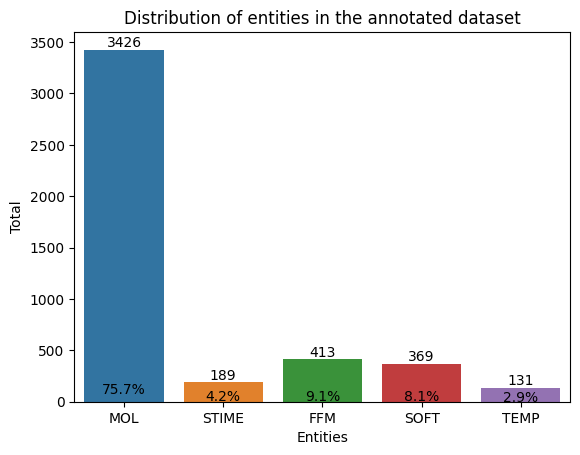

In [2]:
path = "../annotations/"
name_ents = ["MOL", "STIME", "FFM", "SOFT", "TEMP"]
n_ents = {label: 0 for label in name_ents}
total = 0

# Get numbers and percentage for each entity
for json_name in glob.glob(path + "*.json"):
    with open(json_name) as json_file:
        annotations = json.load(json_file)["annotations"][0][1]
        for _, _, label in annotations["entities"]:
            n_ents[label] += 1
            total += 1

# Create a pandas DataFrame with the percentage and total number of sample entities.
df = pd.DataFrame.from_dict(
    {"Percentage": {label: n_ents[label] / total * 100 for label in name_ents},
     "Total": n_ents}
)

# Display a bar plot for each entity
ax = sns.barplot(x=df.index, y='Total', data=df)
plt.xlabel("Entities")
plt.title("Distribution of entities in the annotated dataset")

# Add the number of sample entities and a percentage for each dedicated bar
for i, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height(),
            f"{int(df.iloc[i]['Total'])}",
            ha='center',
            va='bottom')
    ax.text(i, df.iloc[i]['Percentage'] + 1,
            f"{df.iloc[i]['Percentage']:.1f}%",
            ha='center')

As shown in the figure above, there is a large number of "MOL" (molecules) entities which represent more than 76% of all entities. The entities "STIME" (simulation time) and "TEMP" (temperature) are less present in the corpus with a percentage of 4.2% and 2.9% respectively. 

In order to learn each entities, more than 100 entities samples must be present. In our case, this condition is correct.

The distribution of these entities allows us to say that the NER should expect an overrepresentation of the entitie "MOL" in a text compared to the entities "STIME" and "TEMP" for example.

We then split our dataset into 3 parts with 75% of the data for the training (251 in total), 15% of the data for the testing (55 in total) and 10% of the data for the evaluation (35 in total).  

## Naive SpaCy model vs. model with a Transformers-type architecture 

In order to obtain the best possible model, we have looked to create different models. We first created two types of models, a statistical model proposed by SpaCy and a model with a Transformers type architecture. Note here that the vectorisation of tokens by the naive model is based on the use of tok2vec. 

In order to evaluate the performance of our models, we will base on 3 metrics, namely the precision score, the recall score and the f1 score:
* Precison score tells us that the model predicts correctly but not everything.
* Recall score tells us that the model predicts many entities but not necessarily correct.
* F1 score is a [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of the precision score and the recall score.

These scores are obtained with the help of a confusion matrix and using the formulas available [here](https://en.wikipedia.org/wiki/F-score).
For the evaluation of our model, we will use the precision score as we prefer quality to quantity.

The hyperparameters used to design these models are: 
* *Batch size* of 32
* *Learning rate* of 0.001
* For the model with a Transformers-type architecture, we choose to fine-tune a model which is [*allenai/biomed_roberta_base*](https://huggingface.co/allenai/biomed_roberta_base)

### During the training

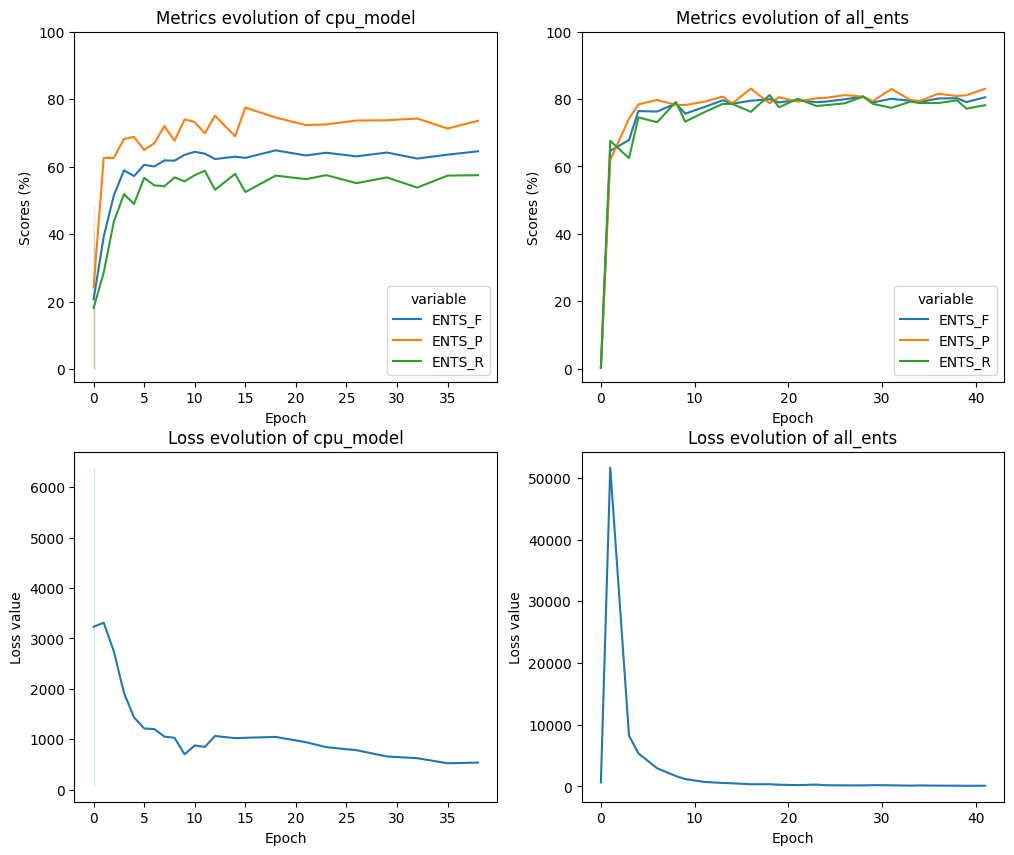

In [3]:
paths_log = ["../results/models/cpu_model/train.log", "../results/models/all_ents/train.log"]
results = tools.get_scores(paths_log)
tools.display_plots(results, paths_log)

From the figures above, we can see that the model with a Transfromers performs better during training. Indeed, all the metrics of the Transformers model are around 80%, whereas the metrics of the naive model are less good. The precision score is around 75%, the recall score is lower with a score of around 50%. We note a difference in the loss value with a better loss value with the Transformers model.

### Benchmark with the evaluation data

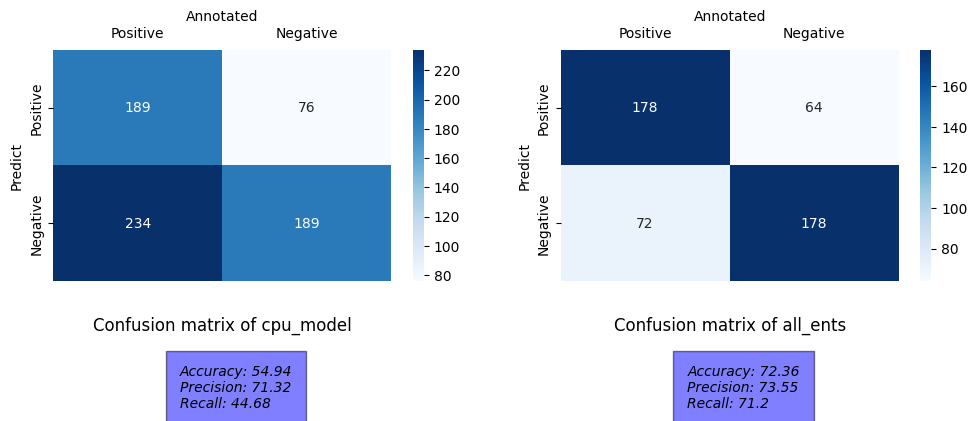

In [4]:
# Get confusion matrix and scores for each models
paths_model = ["../results/models/cpu_model", "../results/models/all_ents"]
cf_mtx, scores = {}, {}
for path_model in paths_model:
    cf_mtx[path_model], scores[path_model] = tools.get_confusion_matrix(path_model, False)

# Display confusion matrix of each models 
tools.display_confusion_matrix(cf_mtx, scores, paths_model)

We then tested the two models on a dataset that was not used for the training. The output illustrates what has been said before,  i.e. that the Transformers model performs better. The precision score obtained with the naive model is 65% and the precision score obtained with the Transformers model is 82%.

Through the evaluation of these models, we have chosen to take the Transformers model which has better results.

## Models on the MOL entity

For the next part of the model building, we have chosen to compare two models, namely a model with only the MOL entity and a model with all entities. The MOL entity corresponds to the most important entity, which is why we create a specific model for this entity. We want to verify that the model with only MOL entity has a better performance in terms of classification.

### During the training

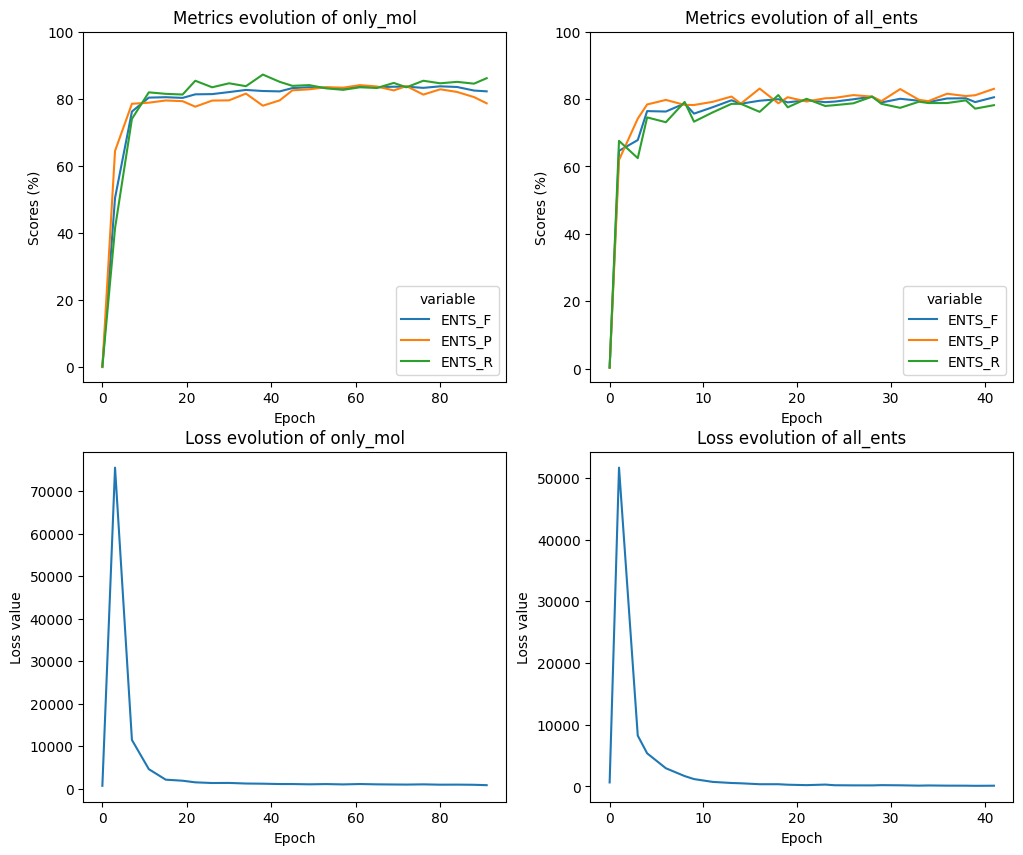

In [5]:
paths_log = ["../results/models/only_mol/train.log", "../results/models/all_ents/train.log"]
results = tools.get_scores(paths_log)
tools.display_plots(results, paths_log)

When create the models, the resulting model metrics are better on the model with only MOL entities with a difference little diffenrences. It cannot be generalised because the evolution of the metrics of the all entities model is an average of all entities, so it's necessary to test with the validation dataset and evaluate the model focused in the MOL entity. 

### Benchmark with the evaluation data

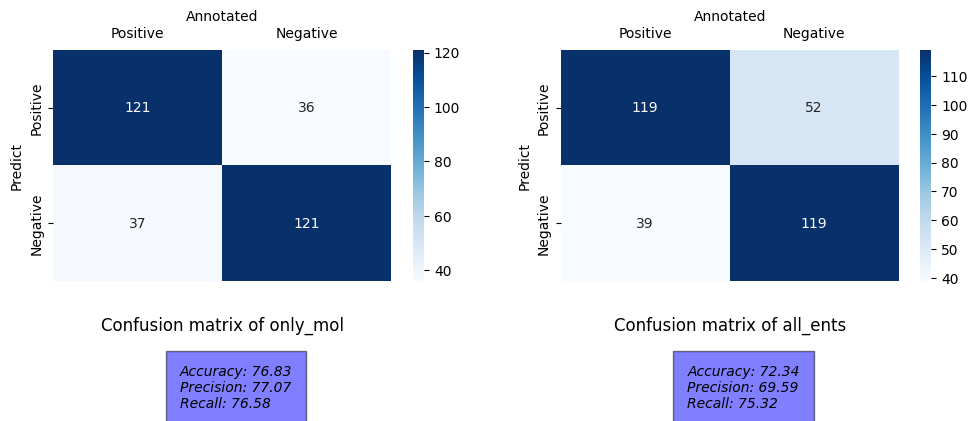

In [7]:
# Get confusion matrix and scores for each models
paths_model = ["../results/models/only_mol", "../results/models/all_ents"]
cf_mtx, scores = {}, {}
for path_model in paths_model:
    cf_mtx[path_model], scores[path_model] = tools.get_confusion_matrix(path_model, True)

# Display confusion matrix of each models 
tools.display_confusion_matrix(cf_mtx, scores, paths_model)

According to the output below, the scores are not very different. Indeed, looking only at the MOL entity, we have a precision score of 77.07% and 69.59% for the "only MOL" model and the "all entities" model respectively. 

These confusion tables illustrate more precisely the difference between the two models on the molecule entities. The difference between the number of false positives (predicted as molecules but not annotated as molecules) is negligible (we are a few annotated entities difference). The same is true for the number of false negatives (predicted to be something else but is actually a molecule). This difference may be insignificant.

## Entity Rulers

In order to maximise our chances to obtain the best possible model, we looked at Entity Rulers.

The [Entity Rulers](https://spacy.io/api/entityruler) can be useful if the corpus on which the model has been trained does not cover all the entities we are interested in, or if we wish to improve the performance of the model on a specific subset of entities, namely molecules. 

We listed a set of molecule names from the [PubChem](https://pubchem.ncbi.nlm.nih.gov/) database and defined them as our patterns for our Entity Rulers.  We have studied the performance with and without Entity Rulers as illustrated in the figures:

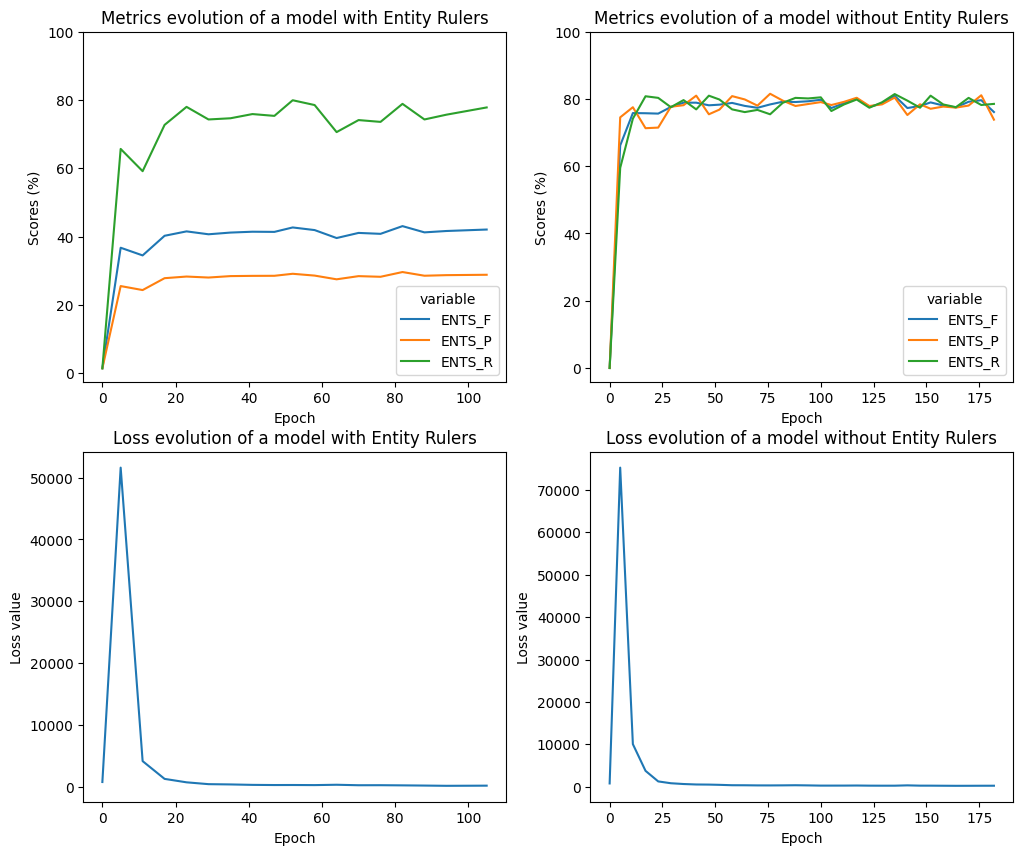

In [7]:
paths_log = ["../results/models/entity_rulers/train.log", "../results/models/all_ents/train.log"]
results = tools.get_scores(paths_log)
tools.display_plots(results, paths_log)

We note a difference in the metrics during training. Indeed, it's important to note that the entity rules can sometimes lead to conflicts with the information learned by the model, which can result in poorer performance. It's important to carefully test and evaluate the effect of adding these entity rulers on the performance of the model before using them.

## Conclusion

From the different models generated, we can conclude that a model based on all entities can be adequate in our study. To improve the performance of this model, it will be necessary to increase the dataset and to optimise the hyperparameters.

## Annex

### NER vs regular expression

The objective of this part is to compare our model using all entities with regular expressions, more precisely for entities like "STIME" (simulation time) or "TEMP" (temperature) which are easy to extract.

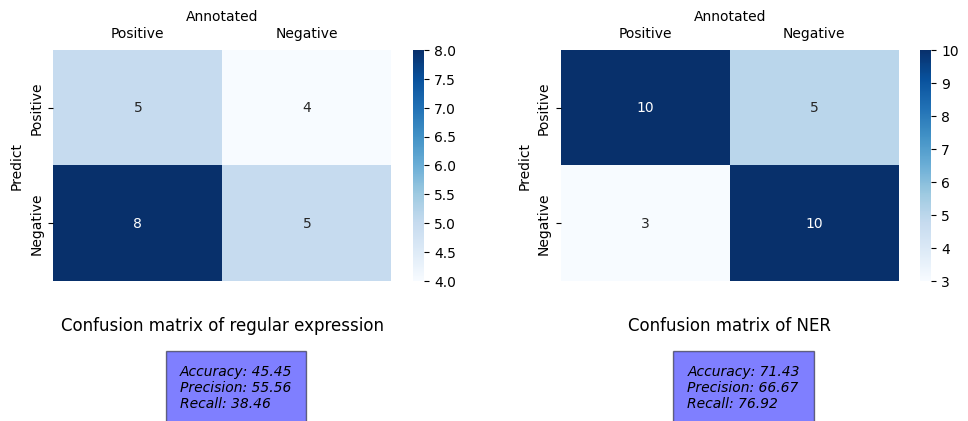

In [9]:
pattern = r"(\d+\.\d+|\d+)\s*([nμm]s)"
ner = spacy.load("../results/models/all_ents/model-best/")
nlp = spacy.blank("en")
models = ["regular expression", "NER"]
cf_mtx = {model: {} for model in models}
scores = {model: [] for model in models}

# Read the evaluation dataset
with open("../results/models/all_ents/eval_data.spacy", "rb") as f:
    doc_bin = spacy.tokens.DocBin().from_bytes(f.read())
    
# Get predicted entities (regular expression and NER) and annoted entities
for model in models :
    tp, fp, fn, tn = 0, 0, 0, 0
    for doc in doc_bin.get_docs(nlp.vocab):
        if model == "NER" :
            doc_ner = ner(doc.text)
            pred_ents = [(ent.text, ent.start_char, ent.end_char) for ent in doc_ner.ents if ent.label_ == "STIME"]
        else :
            matchs = re.finditer(pattern, doc.text)
            pred_ents = [(match.group(), match.start(), match.end()) for match in matchs]
        true_ents = [(ent.text, ent.start_char, ent.end_char) for ent in doc.ents if ent.label_ == "STIME"]
    
        tp += len([ent for ent in true_ents if ent in pred_ents])
        fp += len([ent for ent in pred_ents if ent not in true_ents])
        fn += len([ent for ent in true_ents if ent not in pred_ents])
        tn += len([ent for ent in pred_ents if ent in true_ents])
        
    cf_mtx[model] = pd.DataFrame(
        [[tp, fp], [fn, tn]],
        index=["Positive", "Negative"],
        columns=["Positive", "Negative"],
    )
    acc = (tp + tn) / (tp + fp + fn + tn) * 100
    p = tp / (tp + fp) * 100
    r = tp / (tp + fn) * 100
    scores[model] = [acc, p, r]
tools.display_confusion_matrix(cf_mtx, scores, models)

### Overview

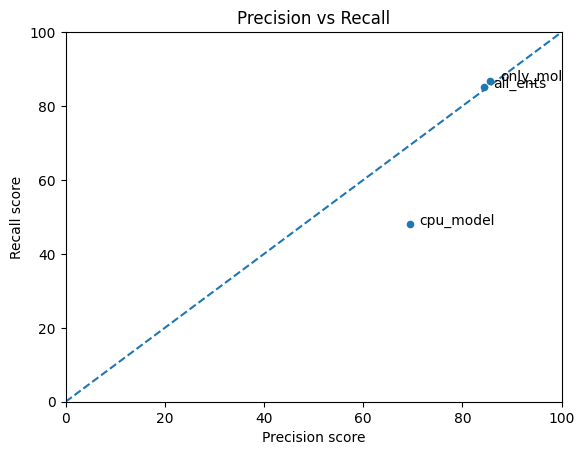

In [10]:
paths_model = [
    "../results/models/only_mol",
    "../results/models/all_ents",
    "../results/models/cpu_model"
]
names_model = [path.split("/")[-1] for path in paths_model]
cf_mtx, scores = {}, {}
pscores, rscores = [], []
for path_model in paths_model:
    _, scores[path_model] = tools.get_confusion_matrix(path_model, True)
    pscores += [scores[path_model][1]]
    rscores += [scores[path_model][2]]

df = pd.DataFrame({"x":pscores, "y":rscores, "model":names_model})

# Plot different scores
ax = df.plot(kind='scatter', x='x', y='y')
plt.title("Precision vs Recall")
plt.plot([0, 100], [0, 100], linestyle="dashed")
plt.ylim(0, 100)
plt.xlim(0, 100)
plt.xlabel("Precision score")
plt.ylabel("Recall score")

# Label each point in scatter plot
for idx, row in df.iterrows():
    ax.annotate(row['model'], (row['x'] + 2, row['y']))